<a href="https://colab.research.google.com/github/erdogan98/DATA_SCIENCE/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/poster_presentation/dataset/train.csv')

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-19468681-416a-bf0b-8c08-645f403de920)


In [5]:
#train_test split
data.shape

data = data.iloc[:150000]

data.shape

(150000, 8)

In [6]:
#preprocess
import os
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import  stopwords
import string
import re
    
data['length'] = data['comment_text'].str.len()

# Convert all messages to lower case
data['comment_text'] = data['comment_text'].str.lower()


# Replace email addresses with 'email'
data['comment_text'] = data['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
data['comment_text'] = data['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
data['comment_text'] = data['comment_text'].str.replace(r'£|\$', 'dollars')

    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
data['comment_text'] = data['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')


# Replace numbers with 'numbr'
data['comment_text'] = data['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')




data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in string.punctuation))


stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))


lem=WordNetLemmatizer()
data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join(
 lem.lemmatize(t) for t in x.split()))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.


In [7]:
data['clean_length'] = data.comment_text.str.len()
data.head(3)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length,clean_length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264,180
1,000103f0d9cfb60f,d'aww! match background colour i'm seemingly s...,0,0,0,0,0,0,112,111
2,000113f07ec002fd,"hey man, i'm really trying edit war. guy const...",0,0,0,0,0,0,233,149


In [64]:
#splitting the data into test and training
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=20)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

'''
test = data.iloc[127656:]
train = data.iloc[:127656]
'''

No. of training examples: 120000
No. of testing examples: 30000


'\ntest = data.iloc[127656:]\ntrain = data.iloc[:127656]\n'

In [65]:
test.shape

(30000, 10)

In [66]:
one_hot_labels=np.array(train.iloc[:,1])
one_hot_labels=np.array(train.iloc[:,2:8])
comments=np.array(train.iloc[:,1])
malignant=np.array(train.iloc[:,2])
highly_malignant=np.array(train.iloc[:,3])
rude = np.array(train.iloc[:,4])
threat=np.array(train.iloc[:,5])
abuse=np.array(train.iloc[:,6])
loathe=np.array(train.iloc[:,7])

loathe[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
test_one_hot_labels=np.array(test.iloc[:,1])
test_one_hot_labels=np.array(test.iloc[:,2:8])
test_comments=np.array(test.iloc[:,1])
test_malignant=np.array(test.iloc[:,2])
test_highly_malignant=np.array(test.iloc[:,3])
test_rude= np.array(test.iloc[:,4])
test_threat=np.array(test.iloc[:,5])
test_abuse=np.array(test.iloc[:,6])
test_loathe=np.array(test.iloc[:,7])

test_loathe[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer()
lang_tokenizer.fit_on_texts(train['comment_text'])

## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
tensor = lang_tokenizer.texts_to_sequences(train['comment_text']) 
tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor)

In [117]:
vocab_size=len(lang_tokenizer.word_counts.keys())
max_len=tensor.shape[-1]
num_classes=6

print((vocab_size))

165238


In [116]:
import torch

print(torch.flatten(tensor))

TypeError: ignored

In [75]:
tensor.shape,one_hot_labels.shape

((120000, 1349), (120000, 6))

In [76]:
#tf.reshape(max_len,[935]
max_len

1349

In [77]:
test_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer()
test_lang_tokenizer.fit_on_texts(test['comment_text'])

## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
test_tensor = lang_tokenizer.texts_to_sequences(test['comment_text']) 
test_tensor=tf.keras.preprocessing.sequence.pad_sequences(test_tensor)


In [84]:
test_vocab_size=len(test_lang_tokenizer.word_counts.keys())
test_max_len=test_tensor.shape[-1]

num_classes=6

print(test_vocab_size)

70399


In [85]:
test_max_len

935

In [86]:
test_tensor.shape

(30000, 935)

In [37]:
test_tensor.shape, test_one_hot_labels.shape

((45000, 935), (45000, 6))

In [38]:
test_max_len

935

In [ ]:
#data processing - create list of comment_texts
train_split = []
for row in train['comment_text']:
    train_split.append(row)

test_split= []
for row in test['comment_text']:
  test_split.append(row)


In [ ]:
from numpy import array
import tensorflow
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Input
from tensorflow.keras.layers import Embedding,LSTM
from tensorflow.keras.models import Model


# define the model
model = Sequential()


input_shape=(max_len,)

inp=Input(input_shape)
emb=Embedding(vocab_size, 30)(inp)
lstm=LSTM(128,return_sequences=False)(emb)
dense=Dense(64)(lstm)
output_layers=[]

#for i in range (0,num_classes):
output_layers.append(Dense(1, activation='sigmoid',name='Malignant')(dense))
output_layers.append(Dense(1, activation='sigmoid',name='Highly_Malignant')(dense))
output_layers.append(Dense(1, activation='sigmoid',name='Rude')(dense))
output_layers.append(Dense(1, activation='sigmoid',name='Threat')(dense))
output_layers.append(Dense(1, activation='sigmoid',name='Abuse')(dense))
output_layers.append(Dense(1, activation='sigmoid',name='Loathe')(dense))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Model (inputs=inp,outputs=output_layers)
model.compile(optimizer=adam, loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()])

# summarize the model
print(model.summary())
# fit the model
model.fit(tensor, [malignant, highly_malignant, rude, threat, abuse, loathe], epochs=25,batch_size=256 ,verbose=1,validation_steps=None)

# evaluate the model
#loss, accuracy = model.evaluate(tensor, [class1, class2, class3, class4, class5, class6], verbose=1)
#print('Accuracy: %f' % (accuracy*100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1349)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1349, 30)     5148300     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          81408       ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['lstm[0][0]']                   
                                                                                              

In [ ]:
import pickle
#model.save('LSTM_NEW.hdf5')
pickle.dump(model, open('LSTM.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://83cf68ab-cb41-4e6f-9236-7a33dd5e23b2/assets


INFO:tensorflow:Assets written to: ram://83cf68ab-cb41-4e6f-9236-7a33dd5e23b2/assets


In [ ]:
import tensorflow as tf

trained_model = tf.keras.models.load_model("/content/drive/MyDrive/ALL_About_AI/LSTM(ep=25-batch256-adam=0.001).hdf5")


In [ ]:
trained_model.build(1349)

In [ ]:
trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1349)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1349, 30)     5145090     ['input_2[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          81408       ['embedding_1[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['lstm_1[0][0]']                 
                                                                                            

In [ ]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
results = trained_model.evaluate(test_tensor,[test_malignant,test_highly_malignant, test_rude, test_threat, test_abuse, test_loathe], batch_size=256)


Evaluate on test data
125/125 [==============================] - 15s 47ms/step - loss: 5.3893 - Malignant_loss: 2.0708 - Highly_Malignant_loss: 0.1956 - Rude_loss: 1.6438 - Threat_loss: 0.0655 - Abuse_loss: 1.2144 - Loathe_loss: 0.1992 - Malignant_accuracy: 0.8190 - Malignant_precision_1: 0.1084 - Malignant_recall_1: 0.1248 - Highly_Malignant_accuracy: 0.9893 - Highly_Malignant_precision_1: 0.0588 - Highly_Malignant_recall_1: 0.0064 - Rude_accuracy: 0.8906 - Rude_precision_1: 0.0309 - Rude_recall_1: 0.0359 - Threat_accuracy: 0.9970 - Threat_precision_1: 0.0000e+00 - Threat_recall_1: 0.0000e+00 - Abuse_accuracy: 0.9260 - Abuse_precision_1: 0.0806 - Abuse_recall_1: 0.0474 - Loathe_accuracy: 0.9886 - Loathe_precision_1: 0.0972 - Loathe_recall_1: 0.0230


In [ ]:
print("test loss, test acc:", "Loss:",results[0],"\n", 
                              "Malignant_Loss:", results[1],'\n', 
                              "Highly_Malignant_Loss:", results[2],'\n',
                              "Rude_loss:",results[3],'\n',
                              "Threat_Loss:",results[4],"\n", 
                              "Abuse_Loss:", results[5],'\n', 
                              "Loathe_Loss:", results[6],'\n',
                              "\n\n",
                              "Malignant_Accuracy:",results[7],'\n',
                              "Malignant_Precision:",results[8],'\n',
                              "Malignant_Recall:",results[9],'\n',
                              "\n\n",
                              "Highly_Malignant_Accuracy:",results[10],'\n',
                              "Highly_Malignant_Precision:",results[11],'\n',
                              "Highly_Malignant_Recall:",results[12],'\n',
                              "\n\n",
                              "Rude_Accuracy:",results[13],'\n',
                              "Rude_Precision:",results[14],'\n',
                              "Rude_Recall:", results[15],"\n",
                              "\n\n",
                              "Threat_Accuracy:",results[16],'\n',
                              "Threat_Precision:",results[17],'\n',
                              "Threat_Recall:",results[18],'\n',
                              "\n\n",
                              "Abuse_Accuracy:",results[19],'\n',
                              "Abuse_Precision:",results[20],'\n',
                              "Abuse_Recall:",results[21],'\n',
                              "\n\n",
                              "Loathe_Accuracy:",results[22],'\n',
                              "Loathe_Precision:",results[23],'\n',
                              "Loathe_Recall:", results[24],"\n")

test loss, test acc: Loss: 5.389316082000732 
 Malignant_Loss: 2.0707998275756836 
 Highly_Malignant_Loss: 0.19561278820037842 
 Rude_loss: 1.6438016891479492 
 Threat_Loss: 0.06549359112977982 
 Abuse_Loss: 1.2144418954849243 
 Loathe_Loss: 0.19916540384292603 
 

 Malignant_Accuracy: 0.8190192580223083 
 Malignant_Precision: 0.10837861150503159 
 Malignant_Recall: 0.12479420751333237 
 

 Highly_Malignant_Accuracy: 0.989315390586853 
 Highly_Malignant_Precision: 0.05882352963089943 
 Highly_Malignant_Recall: 0.006430868059396744 
 

 Rude_Accuracy: 0.8905530571937561 
 Rude_Precision: 0.03086419776082039 
 Rude_Recall: 0.035949669778347015 
 

 Threat_Accuracy: 0.9969606995582581 
 Threat_Precision: 0.0 
 Threat_Recall: 0.0 
 

 Abuse_Accuracy: 0.9259909391403198 
 Abuse_Precision: 0.08064515888690948 
 Abuse_Recall: 0.047408342361450195 
 

 Loathe_Accuracy: 0.9886260628700256 
 Loathe_Precision: 0.0972222238779068 
 Loathe_Recall: 0.02295081876218319 



In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = trained_model.predict(test_tensor[:1])
print("predictions shape:", np.shape(predictions))

Generate predictions for 3 samples
predictions shape: (6, 1, 1)


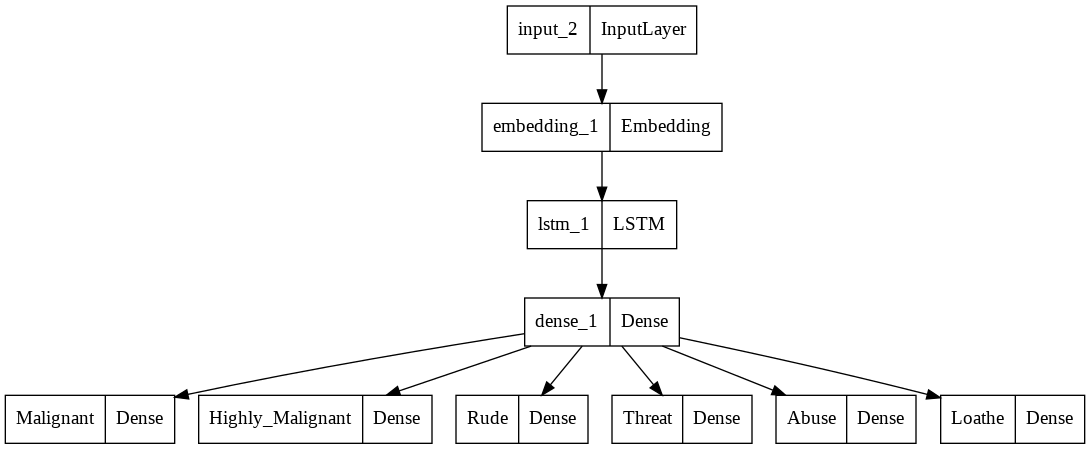

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')